In [1]:
%run "QS_1.ipynb"
transaction['DATE'] = pd.to_datetime(transaction['DATE'], origin='1899-12-30', unit='D')
transaction['year_mm']=transaction['DATE'].dt.strftime('%Y%m').astype(int)
ts=transaction.groupby(['year_mm','STORE_NBR'])['TOT_SALES'].sum().reset_index()
NoC=transaction.groupby(['year_mm','STORE_NBR'])['LYLTY_CARD_NBR'].nunique().reset_index()
TxNo=transaction.groupby(['year_mm','STORE_NBR'])['TXN_ID'].nunique().reset_index()
Pq=transaction.groupby(['year_mm','STORE_NBR'])['PROD_QTY'].sum().reset_index()
matrix=pd.merge(ts,NoC,on=['year_mm','STORE_NBR'])
matrix=pd.merge(TxNo,matrix,on=['year_mm','STORE_NBR'])
matrix=pd.merge(Pq,matrix,on=['year_mm','STORE_NBR'])
matrix.rename(columns={
    'STORE_NBR':'Store Number',
    'PROD_QTY':'Total Chips',
    'TXN_ID':' Number of Transactions',
    'LYLTY_CARD_NBR':'Number of Customers',
    'TOT_SALES':'Total Sales'},inplace=True)
pre_trial_store=matrix[matrix['year_mm']<201902]
months_per_store=matrix.groupby('Store Number')['year_mm'].nunique()
a=months_per_store[months_per_store==12].index
pre_trial_store= pre_trial_store[pre_trial_store['Store Number'].isin(a)]
pre_trial_store.head(2)

,year_mm,Store Number,Total Chips,Number of Transactions,Total Sales,Number of Customers
0,201807,1,62,52,206.9,49
1,201807,2,46,41,150.8,39


In [2]:
import numpy as np
import pandas as pd

def Best_Control_Store(Trial, pre_trial_store):

    C1 = pre_trial_store[pre_trial_store['Store Number'] == Trial]
    C2 = pre_trial_store[pre_trial_store['Store Number'] != Trial]
    Candidate_stores = C2['Store Number'].unique()

    results = []
    for store in Candidate_stores:
        candidate_data = C2[C2['Store Number'] == store]
        merged = pd.merge(
            C1[['year_mm', 'Total Sales', 'Number of Customers']],
            candidate_data[['year_mm', 'Total Sales', 'Number of Customers']],
            on='year_mm',
            suffixes=('_trial', '_control')
        )
        corr_sales = np.corrcoef(merged['Total Sales_trial'], merged['Total Sales_control'])[0,1]
        corr_customers = np.corrcoef(merged['Number of Customers_trial'], merged['Number of Customers_control'])[0,1]

        mag_sales = np.mean(abs(merged['Total Sales_trial'] - merged['Total Sales_control'])) / np.mean(merged['Total Sales_trial'])
        mag_customers = np.mean(abs(merged['Number of Customers_trial'] - merged['Number of Customers_control'])) / np.mean(merged['Number of Customers_trial'])
        final_score = (corr_sales + corr_customers) / 2 + (1 - (mag_sales + mag_customers) / 2)

        results.append({
            'Candidate_Store': store,
            'corr_sales': corr_sales,
            'corr_customers': corr_customers,
            'mag_sales': mag_sales,
            'mag_customers': mag_customers,
            'final_score': final_score
        })

    results_matrix = pd.DataFrame(results)
    best_store = results_matrix.loc[results_matrix['final_score'].idxmax(), 'Candidate_Store']

    print(f"\n Best control store for trial store {Trial} is: {best_store}")
    return results_matrix, best_store
    
results_77, control_77 = Best_Control_Store(77, pre_trial_store)
results_86, control_86 = Best_Control_Store(86, pre_trial_store)
results_88, control_88 = Best_Control_Store(88, pre_trial_store)


 Best control store for trial store 77 is: 233

 Best control store for trial store 86 is: 155

 Best control store for trial store 88 is: 237


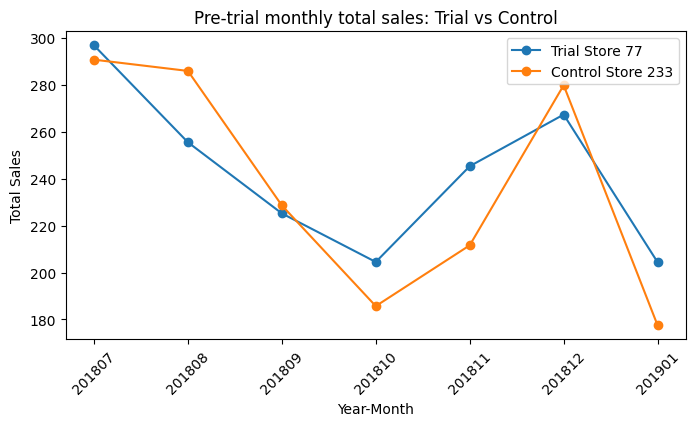

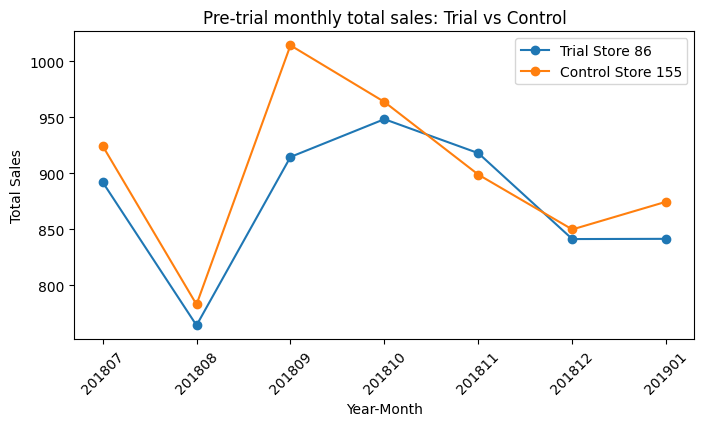

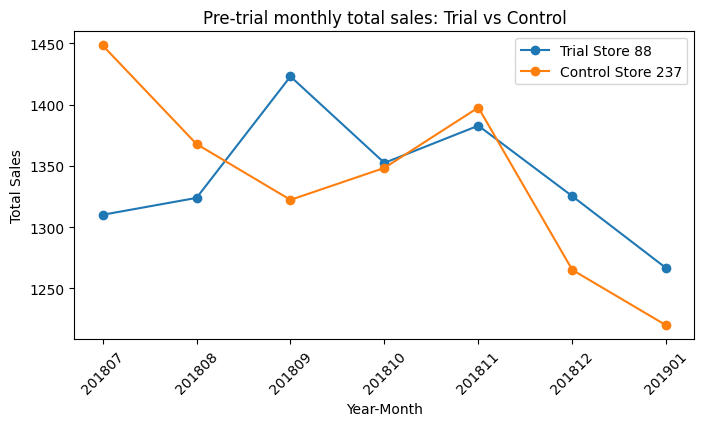

In [11]:
import matplotlib.pyplot as plt
def plot(trial,control):
    Trial1=pre_trial_store[pre_trial_store['Store Number']==trial]
    Trial1_grouped = Trial1.groupby('year_mm')['Total Sales'].sum().reset_index()
    Control1=pre_trial_store[pre_trial_store['Store Number']==control]
    Control1_grouped = Control1.groupby('year_mm')['Total Sales'].sum().reset_index()
    plt.figure(figsize=(8,4))
    plt.plot(Trial1_grouped['year_mm'].astype(str), Trial1_grouped['Total Sales'], 
         marker='o', label='Trial Store '+str (trial))
    plt.plot(Control1_grouped['year_mm'].astype(str), Control1_grouped['Total Sales'], 
         marker='o', label='Control Store '+str (control))
    plt.xlabel('Year-Month')
    plt.ylabel('Total Sales')
    plt.title('Pre-trial monthly total sales: Trial vs Control')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
plot(77,233)
plot(86,155)
plot(88,237)